In [1]:
using DataFrames
using CSV
using Statistics

# CSV dosyasını oku
df = DataFrame(CSV.File("movie.csv"))

# veri sayımıza ve özellik sayımıza bakmak için datamızın boyutunu inceleyelim
println(size(df))

(2187, 10)


In [2]:
column_remove = :"Description"

# DataFrame'den sütunu sil
select!(df, Not(column_remove))


Row,VoteCount,Rating,Year,Title,Genres,Season_Count,Episode_Count,Production_Companies,Actors
,Float64,Float64?,String15,String,String,String15,String7,String?,String?
1,105.0,7.2,2023–,Adalett,"Action, Back to top",1 seasons,10,Vernant DP,"Yurdaer Okur, Burak Sergen, Erdem Kaynarca, Yurdaer Okur, Burak Sergen, Erdem Kaynarca"
2,12.0,4.5,2005–,%100 Futbol,"Sport, Back to top",1 seasons,9,missing,"Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova, Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova"
3,454.0,7.7,2014–2015,1 Erkek 1 Kadin 2 Cocuk,"Comedy, Back to top",1 seasons,33,missing,"Demet Evgar, Emre Karayel, Demet Evgar, Emre Karayel"
4,5700.0,7.8,2008–2015,1 Kadın 1 Erkek,"Comedy, Back to top",8 seasons,435,"Bando TV, 1k1e Production, Ortaks Yapim","Demet Evgar, Emre Karayel, Deniz Degirmenci, Demet Evgar, Emre Karayel, Deniz Degirmenci"
5,2200.0,7.8,2020–,10 Bin Adim,"Comedy, Drama, Back to top",2 seasons,20,Zamkinos,"Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer, Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer"
6,70.0,8.0,2021,103 Gol,"Documentary, Sport, Back to top",1 seasons,4,missing,"Toni Schumacher, Aykut Kocaman, Ridvan Dilmen, Toni Schumacher, Aykut Kocaman, Ridvan Dilmen"
7,0.0,missing,2010,12 Eylül 1980 Darbe,"Documentary, Back to top",1 seasons,4,missing,"Onur Ayçelik, Aynur Alp, Mehmet Sarikaya, Onur Ayçelik, Aynur Alp, Mehmet Sarikaya"
8,0.0,missing,2017,15 Dakika,"Documentary, Biography, Back to top",1 seasons,3,missing,"Yasar Duran, Fevzi Tuncay, Ciguli, Yasar Duran, Fevzi Tuncay, Ciguli"
9,12.0,3.4,2010–,2.Sayfa,"News, Talk-Show, Back to top",4 years,10,missing,"Müge Dagistanli, Gülsen Yüksel, Emir can Yurtlak, Müge Dagistanli, Gülsen Yüksel, Emir can Yurtlak"


In [3]:
#Öncelikle boş değerleri kontrol edelim 
missing_counts = sum.(ismissing, eachcol(df))
column_names = names(df)

for (col_name, missing_count) in zip(column_names, missing_counts)
    println("$(col_name): $(missing_count) missing values")
end

println(size(df))


VoteCount: 0 missing values
Rating: 674 missing values
Year: 0 missing values
Title: 0 missing values
Genres: 0 missing values
Season_Count: 0 missing values
Episode_Count: 0 missing values
Production_Companies: 594 missing values
Actors: 147 missing values
(2187, 9)


#### Önce Data setini düzenlemeliyiz, verisetimizi incelediğimizde aynı dizilere ait tekrar eden veriler bulunmakta bu yüzden geriye sadece bir tanesi kalacak şekilde düzenleme yapalım

In [4]:
#tekrar eden verilerden sadece 1 tanesi kalacak şekilde düzenleme yapmalıyız, Dizi ismine yani Title göre
#temizleme işlemi yapabilir , önceki NaN değeri kontrolunde Title da NaN değeri olmadığından kodu sorunsuz çalıştırabiliriz
# 'Title' sütununa göre tekrarları kaldırıyoruz, tekrar edenlerden sadece ilkini tutuyoruz
df_unique_titles = unique(df, :Title, keep=:first)

println(size(df))

(2187, 9)


#### 2277 veriden gereksiz tekrar eden verilerden kurtulduktan sonra geriye 2187 veri kalmış oldu.

## NULL DEĞERLERİNDEN KURTULMA 

### Sayısal Değişkenlerin null değerlerini doldurma

In [5]:
# yeni datasetimizdeki null değerleri kontrol edelim
missing_counts = sum.(ismissing, eachcol(df))
column_names = names(df)

for (col_name, missing_count) in zip(column_names, missing_counts)
    println("$(col_name): $(missing_count) missing values")
end

println(size(df))

VoteCount: 0 missing values
Rating: 674 missing values
Year: 0 missing values
Title: 0 missing values
Genres: 0 missing values
Season_Count: 0 missing values
Episode_Count: 0 missing values
Production_Companies: 594 missing values
Actors: 147 missing values
(2187, 9)


# NOT
### Episodes _count sütununda her ne kadar boş değer yokmuş gibi gözüksede içerisinde Unknown değerler bulunmaktadır dolayısıyla bu sorunu gidermeliyiz öncelikle:
* Önce Episode_Count sütunun tipini öğrenelim
* Daha sonra int'e çevirelim ve Unknown değerlerini 0 a eşitleyelim
* 0'a eşitlediğimiz Unknown değerlerini, sütundaki diğer verilerin ortalamasıyla değiştirelim

In [6]:
# Episode_Count sütununun tipini öğren
episode_count_type = eltype(df.Episode_Count)
println("Episode_Count sütununun tipi: $episode_count_type")

Episode_Count sütununun tipi: String7


In [7]:
# "Unknown" değerleri "missing" ile değiştirin
df.Episode_Count .= replace(df.Episode_Count, "Unknown" => missing)

# Değerleri Integer'a çevirin ve "missing" değerleri sıfıra çevirin
parsed_values = parse.(Int, coalesce.(df.Episode_Count, "0"))

# Sıfır olan değerleri missing ile değiştirin
parsed_values .= coalesce.(parsed_values, missing)

# Missing değerleri sıfır ile doldurun
filled_values = coalesce.(parsed_values, 0)

# 0 değerlerini sütunun ortalama değeri ile değiştirin
nonzero_mean = mean(skipmissing(parsed_values))
nonzero_mean = round(nonzero_mean)
filled_values[filled_values .== 0] .= nonzero_mean

# "Episode_Count" sütununu güncelleyin
df.Episode_Count .= filled_values



2187-element Vector{Int64}:
  10
   9
  33
 435
  20
   4
   4
   3
  10
  25
  38
  34
  12
   ⋮
  10
  26
   1
   9
   4
  13
  42
   8
   9
   3
 102
  29

In [8]:
first(df, 14)

Row,VoteCount,Rating,Year,Title,Genres,Season_Count,Episode_Count,Production_Companies,Actors
,Float64,Float64?,String15,String,String,String15,Int64,String?,String?
1,105.0,7.2,2023–,Adalett,"Action, Back to top",1 seasons,10,Vernant DP,"Yurdaer Okur, Burak Sergen, Erdem Kaynarca, Yurdaer Okur, Burak Sergen, Erdem Kaynarca"
2,12.0,4.5,2005–,%100 Futbol,"Sport, Back to top",1 seasons,9,missing,"Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova, Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova"
3,454.0,7.7,2014–2015,1 Erkek 1 Kadin 2 Cocuk,"Comedy, Back to top",1 seasons,33,missing,"Demet Evgar, Emre Karayel, Demet Evgar, Emre Karayel"
4,5700.0,7.8,2008–2015,1 Kadın 1 Erkek,"Comedy, Back to top",8 seasons,435,"Bando TV, 1k1e Production, Ortaks Yapim","Demet Evgar, Emre Karayel, Deniz Degirmenci, Demet Evgar, Emre Karayel, Deniz Degirmenci"
5,2200.0,7.8,2020–,10 Bin Adim,"Comedy, Drama, Back to top",2 seasons,20,Zamkinos,"Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer, Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer"
6,70.0,8.0,2021,103 Gol,"Documentary, Sport, Back to top",1 seasons,4,missing,"Toni Schumacher, Aykut Kocaman, Ridvan Dilmen, Toni Schumacher, Aykut Kocaman, Ridvan Dilmen"
7,0.0,missing,2010,12 Eylül 1980 Darbe,"Documentary, Back to top",1 seasons,4,missing,"Onur Ayçelik, Aynur Alp, Mehmet Sarikaya, Onur Ayçelik, Aynur Alp, Mehmet Sarikaya"
8,0.0,missing,2017,15 Dakika,"Documentary, Biography, Back to top",1 seasons,3,missing,"Yasar Duran, Fevzi Tuncay, Ciguli, Yasar Duran, Fevzi Tuncay, Ciguli"
9,12.0,3.4,2010–,2.Sayfa,"News, Talk-Show, Back to top",4 years,10,missing,"Müge Dagistanli, Gülsen Yüksel, Emir can Yurtlak, Müge Dagistanli, Gülsen Yüksel, Emir can Yurtlak"


#### Görüldüğü üzere daha önce 14 satırdaki verimizin Episode_Count değeri Unknown iken artık diğer değerlerin ortalaması yani 26 ile doldurulmuştur.

#### Diğer bir sayısal değişken olan Rating Null değerlerini düzeltelim

In [9]:
# Rating sütunundaki missing değerleri sütunun ortalama değeri ile doldur
mean_rating = mean(skipmissing(df.Rating))
df.Rating .= coalesce.(df.Rating, mean_rating)


2187-element Vector{Float64}:
 7.2
 4.5
 7.7
 7.8
 7.8
 8.0
 5.667680105750162
 5.667680105750162
 3.4
 7.6
 5.667680105750162
 5.667680105750162
 6.6
 ⋮
 8.7
 5.8
 3.1
 6.4
 5.9
 7.1
 2.6
 1.2
 5.6
 5.2
 9.0
 5.667680105750162

In [10]:
first(df, 14)

Row,VoteCount,Rating,Year,Title,Genres,Season_Count,Episode_Count,Production_Companies,Actors
,Float64,Float64,String15,String,String,String15,Int64,String?,String?
1,105.0,7.2,2023–,Adalett,"Action, Back to top",1 seasons,10,Vernant DP,"Yurdaer Okur, Burak Sergen, Erdem Kaynarca, Yurdaer Okur, Burak Sergen, Erdem Kaynarca"
2,12.0,4.5,2005–,%100 Futbol,"Sport, Back to top",1 seasons,9,missing,"Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova, Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova"
3,454.0,7.7,2014–2015,1 Erkek 1 Kadin 2 Cocuk,"Comedy, Back to top",1 seasons,33,missing,"Demet Evgar, Emre Karayel, Demet Evgar, Emre Karayel"
4,5700.0,7.8,2008–2015,1 Kadın 1 Erkek,"Comedy, Back to top",8 seasons,435,"Bando TV, 1k1e Production, Ortaks Yapim","Demet Evgar, Emre Karayel, Deniz Degirmenci, Demet Evgar, Emre Karayel, Deniz Degirmenci"
5,2200.0,7.8,2020–,10 Bin Adim,"Comedy, Drama, Back to top",2 seasons,20,Zamkinos,"Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer, Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer"
6,70.0,8.0,2021,103 Gol,"Documentary, Sport, Back to top",1 seasons,4,missing,"Toni Schumacher, Aykut Kocaman, Ridvan Dilmen, Toni Schumacher, Aykut Kocaman, Ridvan Dilmen"
7,0.0,5.66768,2010,12 Eylül 1980 Darbe,"Documentary, Back to top",1 seasons,4,missing,"Onur Ayçelik, Aynur Alp, Mehmet Sarikaya, Onur Ayçelik, Aynur Alp, Mehmet Sarikaya"
8,0.0,5.66768,2017,15 Dakika,"Documentary, Biography, Back to top",1 seasons,3,missing,"Yasar Duran, Fevzi Tuncay, Ciguli, Yasar Duran, Fevzi Tuncay, Ciguli"
9,12.0,3.4,2010–,2.Sayfa,"News, Talk-Show, Back to top",4 years,10,missing,"Müge Dagistanli, Gülsen Yüksel, Emir can Yurtlak, Müge Dagistanli, Gülsen Yüksel, Emir can Yurtlak"


## Sayısal Değişkenlerimiz : VoteCount, Rating, Episode_Count 
* ( Episode_Count'a uygulamadık)
### Sayısal Değişkenlerimizi scalerleştirme işlemi yapıyoruz.
### + Peki Neden bu işleme ihtiyacımız var ->  sayısal özellikleri belirli bir aralığa ölçeklendirerek makine öğrenimi modellerinin daha iyi performans göstermesine yardımcı olabilir.


# Scalerleştirme işlemi için Min-Max Scalarizasyon işlemini kullanıyoruz.
using Statistics
# Min-Max ölçeklendirme işlemi
function min_max_scale(x)
    min_val = minimum(x)
    max_val = maximum(x)
    scaled = (x .- min_val) ./ (max_val - min_val)
    return scaled
end

df = transform(df, [:VoteCount, :Rating] .=> min_max_scale .=> [:VoteCount, :Rating])


# Kategorik değişkenlerde işlemler

### Bu kısımda Genres isimli kategorik değişkenimizi sayısal değişkene çeviriyoruz, DataFrame'deki "Genres" sütunundaki her bir öğe için ilgili kategorinin içinde olup olmadığını belirten binary (0 veya 1) değerlerine atıyoruz.

In [11]:
# Yeni bir DataFrame oluştur
new_df = DataFrame();

# Kategori listesi
category = ["Drama", "Family", "Action", "Comedy", "Romance", "Adventure", 
            "Crime", "Thriller", "Horror", "Mystery", "War", "Fantasy", 
            "Sci-Fi", "Music", "Biography", "Documentary", "News", "Sport", 
            "Animation", "Reality-TV", "Talk-Show", "Game-Show", "Back to top"]

# Her bir kategori için yeni sütunları oluştur ve yeni DataFrame'e ekle
for c in category
    new_df[!, Symbol("cat_$(lowercase(c))")] = [occursin(c, string(i)) ? 1 : 0 for i in df.Genres]
end

first(new_df, 20)




Row,cat_drama,cat_family,cat_action,cat_comedy,cat_romance,cat_adventure,cat_crime,cat_thriller,cat_horror,cat_mystery,cat_war,cat_fantasy,cat_sci-fi,cat_music,cat_biography,cat_documentary,cat_news,cat_sport,cat_animation,cat_reality-tv,cat_talk-show,cat_game-show,cat_back to top
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1


In [12]:
# back-to-top değişkeni her veride 1 değerinde yani her verinin içinde olduğu için pek bir anlam ifade etmiyor dolayısıyla bu sütunu siliyoruz
column_to_remove = :"cat_back to top"

# DataFrame'den sütunu sil
select!(new_df, Not(column_to_remove))


Row,cat_drama,cat_family,cat_action,cat_comedy,cat_romance,cat_adventure,cat_crime,cat_thriller,cat_horror,cat_mystery,cat_war,cat_fantasy,cat_sci-fi,cat_music,cat_biography,cat_documentary,cat_news,cat_sport,cat_animation,cat_reality-tv,cat_talk-show,cat_game-show
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [13]:
# Bu kısımda üstte oluşturduğumuz yeni tabloyu kendi verisetimize ekliyoruz
if nrow(df) == nrow(new_df)
    # İki DataFrame'i birleştir
    merged_df = hcat(df, new_df)
    # İlk birkaç satırı gösterme
    first(merged_df, 5)
else
    println("Hata: DataFrame'lerin satır sayıları eşleşmiyor.")
end


Row,VoteCount,Rating,Year,Title,Genres,Season_Count,Episode_Count,Production_Companies,Actors,cat_drama,cat_family,cat_action,cat_comedy,cat_romance,cat_adventure,cat_crime,cat_thriller,cat_horror,cat_mystery,cat_war,cat_fantasy,cat_sci-fi,cat_music,cat_biography,cat_documentary,cat_news,cat_sport,cat_animation,cat_reality-tv,cat_talk-show,cat_game-show
,Float64,Float64,String15,String,String,String15,Int64,String?,String?,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,105.0,7.2,2023–,Adalett,"Action, Back to top",1 seasons,10,Vernant DP,"Yurdaer Okur, Burak Sergen, Erdem Kaynarca, Yurdaer Okur, Burak Sergen, Erdem Kaynarca",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12.0,4.5,2005–,%100 Futbol,"Sport, Back to top",1 seasons,9,missing,"Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova, Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,454.0,7.7,2014–2015,1 Erkek 1 Kadin 2 Cocuk,"Comedy, Back to top",1 seasons,33,missing,"Demet Evgar, Emre Karayel, Demet Evgar, Emre Karayel",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5700.0,7.8,2008–2015,1 Kadın 1 Erkek,"Comedy, Back to top",8 seasons,435,"Bando TV, 1k1e Production, Ortaks Yapim","Demet Evgar, Emre Karayel, Deniz Degirmenci, Demet Evgar, Emre Karayel, Deniz Degirmenci",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2200.0,7.8,2020–,10 Bin Adim,"Comedy, Drama, Back to top",2 seasons,20,Zamkinos,"Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer, Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer",1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### yeni 22 değer daha eklenmiş oldu toplam 31 özelliğimiz var

In [14]:
# Genres Sütununu sayısal değerlere çevirdiğimizden artık genres sütununa ihtiyacımız Kalmadı bu yuzden Genres sütununu kaldırabiliriz
column_to_remove = :"Genres"

# DataFrame'den sütunu sil
select!(merged_df, Not(column_to_remove))

Row,VoteCount,Rating,Year,Title,Season_Count,Episode_Count,Production_Companies,Actors,cat_drama,cat_family,cat_action,cat_comedy,cat_romance,cat_adventure,cat_crime,cat_thriller,cat_horror,cat_mystery,cat_war,cat_fantasy,cat_sci-fi,cat_music,cat_biography,cat_documentary,cat_news,cat_sport,cat_animation,cat_reality-tv,cat_talk-show,cat_game-show
,Float64,Float64,String15,String,String15,Int64,String?,String?,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,105.0,7.2,2023–,Adalett,1 seasons,10,Vernant DP,"Yurdaer Okur, Burak Sergen, Erdem Kaynarca, Yurdaer Okur, Burak Sergen, Erdem Kaynarca",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12.0,4.5,2005–,%100 Futbol,1 seasons,9,missing,"Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova, Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,454.0,7.7,2014–2015,1 Erkek 1 Kadin 2 Cocuk,1 seasons,33,missing,"Demet Evgar, Emre Karayel, Demet Evgar, Emre Karayel",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5700.0,7.8,2008–2015,1 Kadın 1 Erkek,8 seasons,435,"Bando TV, 1k1e Production, Ortaks Yapim","Demet Evgar, Emre Karayel, Deniz Degirmenci, Demet Evgar, Emre Karayel, Deniz Degirmenci",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2200.0,7.8,2020–,10 Bin Adim,2 seasons,20,Zamkinos,"Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer, Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer",1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,70.0,8.0,2021,103 Gol,1 seasons,4,missing,"Toni Schumacher, Aykut Kocaman, Ridvan Dilmen, Toni Schumacher, Aykut Kocaman, Ridvan Dilmen",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
7,0.0,5.66768,2010,12 Eylül 1980 Darbe,1 seasons,4,missing,"Onur Ayçelik, Aynur Alp, Mehmet Sarikaya, Onur Ayçelik, Aynur Alp, Mehmet Sarikaya",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,0.0,5.66768,2017,15 Dakika,1 seasons,3,missing,"Yasar Duran, Fevzi Tuncay, Ciguli, Yasar Duran, Fevzi Tuncay, Ciguli",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
9,12.0,3.4,2010–,2.Sayfa,4 years,10,missing,"Müge Dagistanli, Gülsen Yüksel, Emir can Yurtlak, Müge Dagistanli, Gülsen Yüksel, Emir can Yurtlak",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


### Datasetindeki Diğer bir problem ise Actor isimleri 2 kez tekrar edilmiş bu durumu da düzeltelim

In [15]:
# Actors sütunundaki mevcut String değerleri düzeltme
merged_df.Actors .= [ismissing(actors) ? missing : join(unique(split(actors, ", ")), ", ") for actors in merged_df.Actors]

# İlk birkaç satırı gösterme
first(merged_df, 5)



Row,VoteCount,Rating,Year,Title,Season_Count,Episode_Count,Production_Companies,Actors,cat_drama,cat_family,cat_action,cat_comedy,cat_romance,cat_adventure,cat_crime,cat_thriller,cat_horror,cat_mystery,cat_war,cat_fantasy,cat_sci-fi,cat_music,cat_biography,cat_documentary,cat_news,cat_sport,cat_animation,cat_reality-tv,cat_talk-show,cat_game-show
,Float64,Float64,String15,String,String15,Int64,String?,String?,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,105.0,7.2,2023–,Adalett,1 seasons,10,Vernant DP,"Yurdaer Okur, Burak Sergen, Erdem Kaynarca",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12.0,4.5,2005–,%100 Futbol,1 seasons,9,missing,"Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,454.0,7.7,2014–2015,1 Erkek 1 Kadin 2 Cocuk,1 seasons,33,missing,"Demet Evgar, Emre Karayel",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5700.0,7.8,2008–2015,1 Kadın 1 Erkek,8 seasons,435,"Bando TV, 1k1e Production, Ortaks Yapim","Demet Evgar, Emre Karayel, Deniz Degirmenci",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2200.0,7.8,2020–,10 Bin Adim,2 seasons,20,Zamkinos,"Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer",1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Year Sütunundaki verileri de düzeltelim
* String tipindeki Year sütununu int tipinde Başlangıç ve bitiş olarak iki sütuna ayırabilir ve veri setimize ekleyebiliriz

##### Başlangıç yılı

In [16]:
# 'Year' sütunundaki tarih değerlerini düzeltmek için bir fonksiyon
function fix_year(year)
    if '–' in year
        # Eğer tarih aralığı varsa, ilk yılı al
        return parse(Int, split(year, '–')[1])
    else
        return parse(Int, year)
    end
end

# 'Year' sütununu düzelt
merged_df.Release_Year = map(fix_year, merged_df.Year)



2187-element PooledArrays.PooledVector{Int64, UInt32, Vector{UInt32}}:
 2023
 2005
 2014
 2008
 2020
 2021
 2010
 2017
 2010
 2013
 2013
 2011
 2012
    ⋮
 1998
 2015
 2013
 2012
 2013
 2017
 2007
 2021
 2016
 2023
 2018
 2012

In [17]:
merged_df = merged_df[.!ismissing.(merged_df[:, "Year"]), :]

# Dizinin bitip bitmediğini belirleyen yeni bir sütun eklenir
merged_df[!, "IsEnded"] = map(x -> !endswith(x, "–"), merged_df[:, "Year"]) 

# IsEnded sütunundaki true ve false değerlerini 1 ve 0 olarak değiştirilir
merged_df[!, "IsEnded"] = replace(merged_df[:, "IsEnded"], true => 1, false => 0)



2187-element PooledArrays.PooledVector{Int64, UInt32, Vector{UInt32}}:
 0
 0
 1
 1
 0
 1
 1
 1
 0
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0
 0
 1

In [18]:
# Plots kütüphanesini yükleyin
using Pkg
Pkg.add("Plots")
Pkg.add("StatsPlots")
import Pkg
Pkg.add("GR")

   Resolving package versions...
  No Changes to `C:\Users\Aleyna\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Aleyna\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Aleyna\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Aleyna\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Aleyna\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Aleyna\.julia\environments\v1.9\Manifest.toml`


#### Year değişkenimizi Başlangıç ve Bitiş yılı olarak 2 değişkene ayırdığımızdan, Year değişkenine ihtiyaç kalmamıştır bu yüzden Data setimizden çıkarabiliriz

In [19]:
column_remove = :"Year"

# DataFrame'den sütunu sil
select!(merged_df, Not(column_remove))

Row,VoteCount,Rating,Title,Season_Count,Episode_Count,Production_Companies,Actors,cat_drama,cat_family,cat_action,cat_comedy,cat_romance,cat_adventure,cat_crime,cat_thriller,cat_horror,cat_mystery,cat_war,cat_fantasy,cat_sci-fi,cat_music,cat_biography,cat_documentary,cat_news,cat_sport,cat_animation,cat_reality-tv,cat_talk-show,cat_game-show,Release_Year,IsEnded
,Float64,Float64,String,String15,Int64,String?,String?,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,105.0,7.2,Adalett,1 seasons,10,Vernant DP,"Yurdaer Okur, Burak Sergen, Erdem Kaynarca",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2023,0
2,12.0,4.5,%100 Futbol,1 seasons,9,missing,"Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2005,0
3,454.0,7.7,1 Erkek 1 Kadin 2 Cocuk,1 seasons,33,missing,"Demet Evgar, Emre Karayel",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2014,1
4,5700.0,7.8,1 Kadın 1 Erkek,8 seasons,435,"Bando TV, 1k1e Production, Ortaks Yapim","Demet Evgar, Emre Karayel, Deniz Degirmenci",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2008,1
5,2200.0,7.8,10 Bin Adim,2 seasons,20,Zamkinos,"Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer",1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,0
6,70.0,8.0,103 Gol,1 seasons,4,missing,"Toni Schumacher, Aykut Kocaman, Ridvan Dilmen",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2021,1
7,0.0,5.66768,12 Eylül 1980 Darbe,1 seasons,4,missing,"Onur Ayçelik, Aynur Alp, Mehmet Sarikaya",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2010,1
8,0.0,5.66768,15 Dakika,1 seasons,3,missing,"Yasar Duran, Fevzi Tuncay, Ciguli",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,2017,1
9,12.0,3.4,2.Sayfa,4 years,10,missing,"Müge Dagistanli, Gülsen Yüksel, Emir can Yurtlak",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2010,0


In [20]:
# 'Season_Count' sütununu döngü ile işleyerek sadece sayıyı al
merged_df.Season_Count = [occursin(r"(\d+)", val) ? parse(Int, match(r"(\d+)", val).match) : missing for val in merged_df.Season_Count]


2187-element Vector{Int64}:
 1
 1
 1
 8
 2
 1
 1
 1
 4
 1
 2
 2
 2
 ⋮
 1
 2
 1
 1
 1
 1
 1
 1
 1
 1
 3
 2

In [21]:
# İlk birkaç satırı gösterme
first(merged_df, 15)

Row,VoteCount,Rating,Title,Season_Count,Episode_Count,Production_Companies,Actors,cat_drama,cat_family,cat_action,cat_comedy,cat_romance,cat_adventure,cat_crime,cat_thriller,cat_horror,cat_mystery,cat_war,cat_fantasy,cat_sci-fi,cat_music,cat_biography,cat_documentary,cat_news,cat_sport,cat_animation,cat_reality-tv,cat_talk-show,cat_game-show,Release_Year,IsEnded
,Float64,Float64,String,Int64,Int64,String?,String?,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,105.0,7.2,Adalett,1,10,Vernant DP,"Yurdaer Okur, Burak Sergen, Erdem Kaynarca",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2023,0
2,12.0,4.5,%100 Futbol,1,9,missing,"Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2005,0
3,454.0,7.7,1 Erkek 1 Kadin 2 Cocuk,1,33,missing,"Demet Evgar, Emre Karayel",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2014,1
4,5700.0,7.8,1 Kadın 1 Erkek,8,435,"Bando TV, 1k1e Production, Ortaks Yapim","Demet Evgar, Emre Karayel, Deniz Degirmenci",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2008,1
5,2200.0,7.8,10 Bin Adim,2,20,Zamkinos,"Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer",1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,0
6,70.0,8.0,103 Gol,1,4,missing,"Toni Schumacher, Aykut Kocaman, Ridvan Dilmen",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2021,1
7,0.0,5.66768,12 Eylül 1980 Darbe,1,4,missing,"Onur Ayçelik, Aynur Alp, Mehmet Sarikaya",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2010,1
8,0.0,5.66768,15 Dakika,1,3,missing,"Yasar Duran, Fevzi Tuncay, Ciguli",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,2017,1
9,12.0,3.4,2.Sayfa,4,10,missing,"Müge Dagistanli, Gülsen Yüksel, Emir can Yurtlak",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2010,0


## Son Olarak temiz verisetimizi csv dosyası olarak kaydediyoruz.

In [22]:
# Temizlenmiş veriyi CSV dosyasına kaydet
CSV.write("temiz_dataset.csv", merged_df)


"temiz_dataset.csv"

### NOT : Boyut Azaltma işlemi modelin verdiği sonuca göre yapılacaktır(overfitting durumu gibi)

## Dikkat : Scaler işlemi yapılmadan önce korelasyon ilişkisine bakılmıştır

In [23]:
using Statistics, GR
# Sadece sayısal değişkenleri seçin
numeric_columns = [:VoteCount, :Rating, :Season_Count, :Episode_Count, :Release_Year]

# Sayısal değişkenleri içeren bir alt veri çerçevesi oluşturun
numeric_df = select(merged_df, numeric_columns)

# Korelasyon matrisini oluşturun
cor_matrix = cor(Matrix(numeric_df))

# Korelasyon matrisini görüntüleyin
display(cor_matrix)


5×5 Matrix{Float64}:
 1.0          0.249316    0.0287131    0.000507894   0.0264355
 0.249316     1.0         0.0190211    0.00735929    0.199271
 0.0287131    0.0190211   1.0          0.564417      0.00742252
 0.000507894  0.00735929  0.564417     1.0          -0.0265212
 0.0264355    0.199271    0.00742252  -0.0265212     1.0

In [2]:
using StatsPlots, DataFrames, CSV
df = DataFrame(CSV.File("yenitemiz_data.csv"))

[ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]


Row,VoteCount,Rating,Title,Season_Count,Episode_Count,Actors,cat_drama,cat_family,cat_action,cat_comedy,cat_romance,cat_adventure,cat_crime,cat_thriller,cat_horror,cat_mystery,cat_war,cat_fantasy,cat_sci-fi,cat_music,cat_biography,cat_documentary,cat_news,cat_sport,cat_animation,cat_reality-tv,cat_talk-show,cat_game-show,Release_Year,IsEnded,Classification_Int
,Float64,Float64,String,Int64,Int64,String?,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,105.0,7.2,Adalett,1,10,"Yurdaer Okur, Burak Sergen, Erdem Kaynarca",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2023,0,1
2,12.0,4.5,%100 Futbol,1,9,"Ridvan Dilmen, Erbatur Ergenekon, Murat Kosova",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2005,0,1
3,454.0,7.7,1 Erkek 1 Kadin 2 Cocuk,1,33,"Demet Evgar, Emre Karayel",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2014,1,1
4,5700.0,7.8,1 Kadın 1 Erkek,8,435,"Demet Evgar, Emre Karayel, Deniz Degirmenci",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2008,1,4
5,2200.0,7.8,10 Bin Adim,2,20,"Engin Günaydin, Devin Özgür Çinar, Bugu Selen Somer",1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,0,2
6,70.0,8.0,103 Gol,1,4,"Toni Schumacher, Aykut Kocaman, Ridvan Dilmen",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2021,1,1
7,0.0,5.66768,12 Eylül 1980 Darbe,1,4,"Onur Ayçelik, Aynur Alp, Mehmet Sarikaya",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2010,1,1
8,0.0,5.66768,15 Dakika,1,3,"Yasar Duran, Fevzi Tuncay, Ciguli",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,2017,1,1
9,12.0,3.4,2.Sayfa,5,460,"Müge Dagistanli, Gülsen Yüksel, Emir can Yurtlak",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2010,0,3


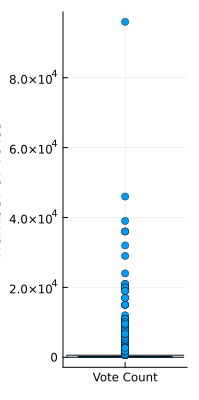

In [3]:
boxplot(["Vote Count"],df.VoteCount, legend = false, size =(200,400),whisker_width = 1, ylabel = "Number of Votes")

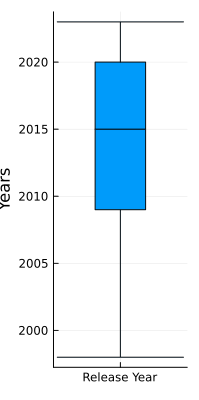

In [4]:
boxplot(["Release Year"],df.Release_Year, legend = false, size =(200,400),whisker_width = 2, ylabel = "Years")

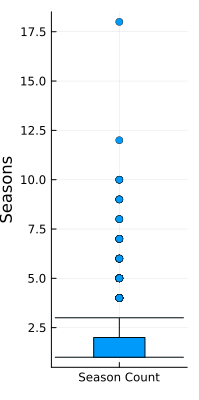

In [5]:
boxplot(["Season Count"],df.Season_Count, legend = false, size =(200,400),whisker_width = 2, ylabel = "Seasons")

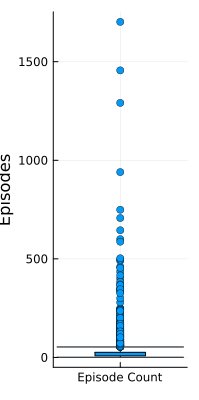

In [6]:
boxplot(["Episode Count"],df.Episode_Count, legend = false, size =(200,400),whisker_width = 2, ylabel = "Episodes")


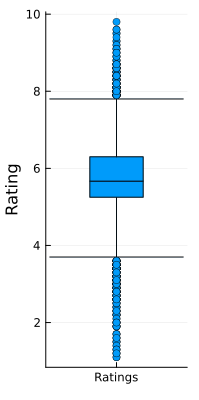

In [7]:
boxplot(["Ratings"],df.Rating, legend = false, size =(200,400),whisker_width = 2, ylabel = "Rating")
